# SETD2
SETD2 is the primary methyltransferase catalyzing H3K36 trimethylation (H3K36me3).
Pathogenic variants in SETD2 are observed in
[Intellectual developmental disorder, autosomal dominant 70	(OMIM:620157)](https://omim.org/entry/620157),
[Luscan-Lumish syndrome	(OMIM:616831)](https://omim.org/entry/616831), and
[Rabin-Pappas syndrome	(OMIM:620155)](https://omim.org/entry/620155).

In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2025-01-16
Using gpsea version 0.9.4


### SETD2
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for SETD2.

In [2]:
from gpsea.preprocessing import configure_default_protein_metadata_service
gene_symbol = 'SETD2'
mane_tx_id = 'NM_014159.7'
mane_protein_id = 'NP_054878.5' # histone-lysine N-methyltransferase SETD2 isoform 1 [Homo sapiens]
pms = configure_default_protein_metadata_service()
protein_meta = pms.annotate(mane_protein_id)

In [3]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store('0.1.24') as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))

cohort_creator = configure_caching_cohort_creator(hpo)
cohort, qc_results = load_phenopackets(  
    phenopackets=phenopackets,
    cohort_creator=cohort_creator,
)
qc_results.summarize()

Individuals Processed: 100%|██████████| 45/45 [00:00<00:00, 168.57 individuals/s]
Validated under permissive policy
No errors or warnings were found


In [4]:
from gpsea.view import CohortViewer

cv = CohortViewer(hpo)
cv.process(cohort, transcript_id=mane_tx_id)

n,HPO Term
29,Delayed speech and language development
19,Macrocephaly
19,Global developmental delay
16,Hypertelorism
14,Hypotonia
12,Autistic behavior
11,Wide nasal bridge
11,Obesity
11,Micrognathia
11,Highly arched eyebrow


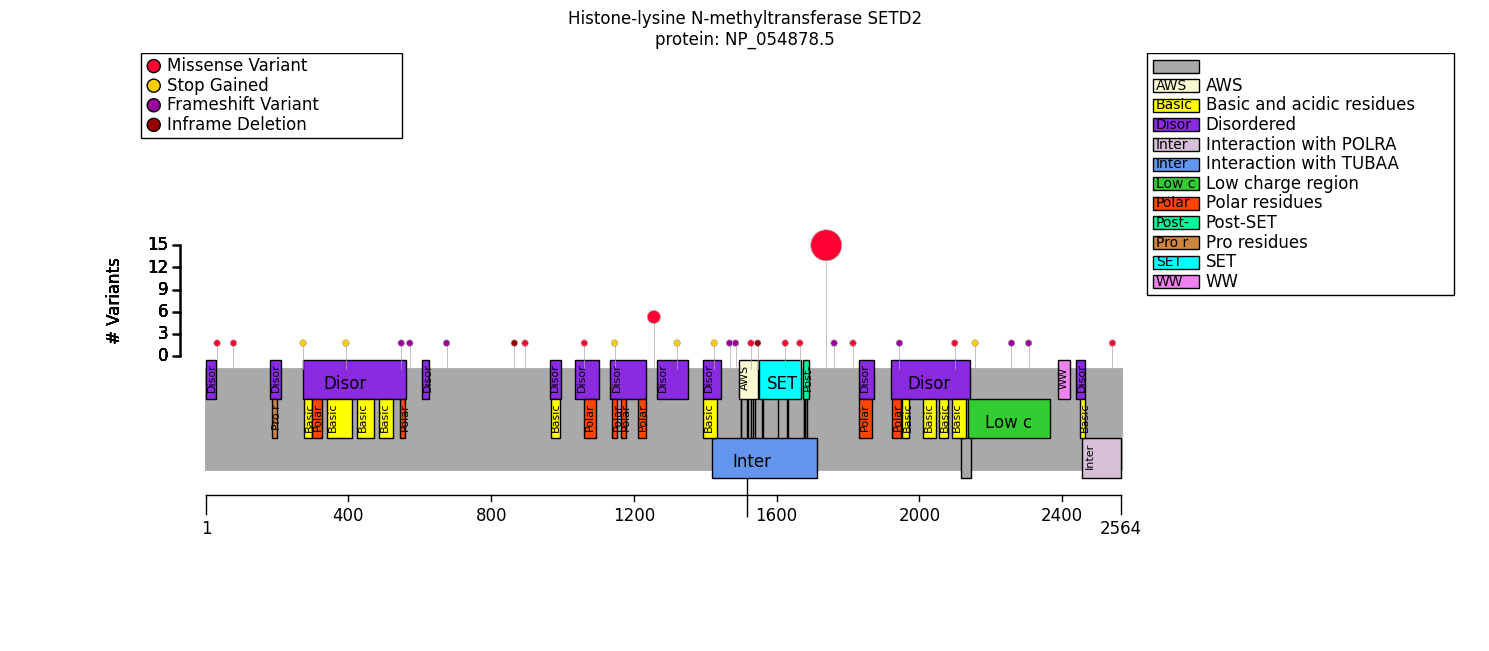

In [5]:
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

setd2_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein(
    protein_metadata=protein_meta,
    cohort=cohort,
    ax=ax,
)
setd2_fig.tight_layout()

# Genotype-Phenotype Correlation (GPC) Analysis

In [6]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest

analysis = configure_hpo_term_analysis(hpo)
pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [7]:
from gpsea.view import MtcStatsViewer
from gpsea.analysis.clf import monoallelic_classifier
from gpsea.analysis.predicate import variant_key

r1740w = variant_key(key="3_47088172_47088172_G_A") # c.5218C>T	p.Arg1740Trp	
r1740q = variant_key(key="3_47088171_47088171_C_T") # c.5219G>A	p.Arg1740Gln

r1740w_clf = monoallelic_classifier(
    a_predicate=r1740w, 
    b_predicate=~r1740w, 
    a_label="Arg1740Trp",
    b_label="Other")

r1740w_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=r1740w_clf,
    pheno_clfs=pheno_clfs,
)

viewer = MtcStatsViewer()
viewer.process(r1740w_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,74
HMF03,Skipping term because of a child term with the same individual counts,2
HMF05,Skipping term because one genotype had zero observations,3
HMF08,Skipping general term,104
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,434


In [8]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=r1740w_result)

Allele group,Arg1740Trp,Other,Corrected p values,p values
Severe global developmental delay [HP:0011344],9/9 (100%),0/12 (0%),0.000082,0.000003
Hypertelorism [HP:0000316],11/11 (100%),5/23 (22%),0.000183,0.000015
Macrocephaly [HP:0000256],0/11 (0%),19/28 (68%),0.001162,0.000145
Delayed ability to walk [HP:0031936],8/8 (100%),1/10 (10%),0.002468,0.000411
Scoliosis [HP:0002650],6/6 (100%),2/14 (14%),0.003467,0.000722
Wide nasal bridge [HP:0000431],9/9 (100%),2/9 (22%),0.008593,0.002262
Ventriculomegaly [HP:0002119],4/4 (100%),2/17 (12%),0.008593,0.002506
Motor delay [HP:0001270],8/8 (100%),6/13 (46%),0.053870,0.017957
Global developmental delay [HP:0001263],9/9 (100%),19/31 (61%),0.099936,0.037476
Delayed speech and language development [HP:0000750],8/8 (100%),21/33 (64%),0.173913,0.079381


In [9]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate import variant_effect

missense = variant_effect(effect=VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)

missense_clf = monoallelic_classifier(
    a_predicate=missense,
    b_predicate=~missense,
    a_label="Missense",
    b_label="Other"
)

missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=missense_clf,
     pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=missense_result)

Allele group,Missense,Other,Corrected p values,p values
Macrocephaly [HP:0000256],4/24 (17%),15/15 (100%),0.000004,1.541715e-07
Scoliosis [HP:0002650],8/13 (62%),0/7 (0%),0.155448,1.465428e-02
Hypertelorism [HP:0000316],13/20 (65%),3/14 (21%),0.155448,1.727201e-02
Hypotonia [HP:0001252],5/13 (38%),9/11 (82%),0.265215,4.717997e-02
Wide nasal bridge [HP:0000431],9/11 (82%),2/7 (29%),0.265215,4.911388e-02
Prominent forehead [HP:0011220],1/9 (11%),7/13 (54%),0.334365,7.430341e-02
Obesity [HP:0001513],4/23 (17%),7/16 (44%),0.533392,1.461149e-01
Intellectual disability [HP:0001249],2/7 (29%),8/12 (67%),0.533392,1.698023e-01
Ventriculomegaly [HP:0002119],5/12 (42%),1/9 (11%),0.533392,1.777974e-01
Delayed ability to walk [HP:0031936],9/15 (60%),0/3 (0%),0.555882,2.058824e-01


In [10]:
from gpsea.analysis.clf import sex_classifier

mf_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=sex_classifier(),
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=mf_result)

Sex,FEMALE,MALE,Corrected p values,p values
Autistic behavior [HP:0000729],7/7 (100%),5/12 (42%),0.247140,0.017405
Broad forehead [HP:0000337],5/6 (83%),4/17 (24%),0.247140,0.018307
Ventriculomegaly [HP:0002119],5/10 (50%),1/11 (9%),0.571207,0.063467
Wide nasal bridge [HP:0000431],8/10 (80%),3/8 (38%),0.977376,0.144796
Severe global developmental delay [HP:0011344],6/10 (60%),3/11 (27%),1.000000,0.198381
Intellectual disability [HP:0001249],2/6 (33%),8/13 (62%),1.000000,0.349845
Delayed speech and language development [HP:0000750],11/17 (65%),18/24 (75%),1.000000,0.507244
Macrocephaly [HP:0000256],7/17 (41%),12/22 (55%),1.000000,0.523107
Attention deficit hyperactivity disorder [HP:0007018],3/7 (43%),3/13 (23%),1.000000,0.612616
Scoliosis [HP:0002650],4/8 (50%),4/12 (33%),1.000000,0.647916


In [11]:
from gpsea.analysis.temporal.endpoint import disease_onset
from gpsea.analysis.temporal.stats import LogRankTest
from gpsea.analysis.temporal import SurvivalAnalysis


idd70 = "OMIM:620157" # Intellectual developmental disorder, autosomal dominant 70
lls = "OMIM:616831" # Luscan-Lumish syndrome
rps = "OMIM:620155" # Rabin-Pappas syndrome
# Test onset of LLS, with 28 individuals

lls_onset = disease_onset(disease_id=lls)

survival_statistic = LogRankTest()
survival_analysis = SurvivalAnalysis(
    statistic=survival_statistic,
)
lls_missense_onset_result = survival_analysis.compare_genotype_vs_survival(
    cohort=cohort,
    gt_clf=missense_clf,
    endpoint=lls_onset,
)
print(f"LLS Onset vs. missense variant p={lls_missense_onset_result.pval:.5f}")

LLS Onset vs. missense variant p=0.00008


Text(2000, 0.5, '$p=0.00008$')

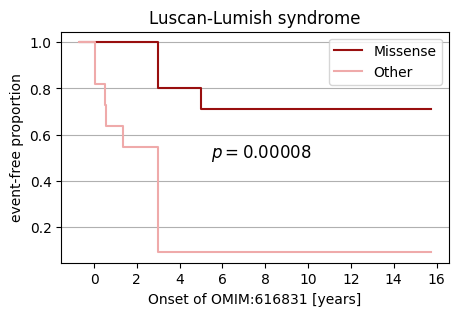

In [12]:
import matplotlib as mpl
from gpsea.model import Age

lls_onset_fig, ax = plt.subplots(figsize=(5, 3))
lls_missense_onset_result.plot_kaplan_meier_curves(ax=ax)
def days_to_years(x, pos):
    return f"{x / 365.25:.1f}"
_ = ax.xaxis.set(
    # Show X axis in years ...
    major_formatter=mpl.ticker.FuncFormatter(lambda x, pos: f"{x / Age.DAYS_IN_YEAR:.0f}"),
    # ... with a tick for every decade
    major_locator=mpl.ticker.MultipleLocator(2 * Age.DAYS_IN_YEAR),
)
_ = ax.set(
    xlabel=lls_onset.name + " [years]",
    ylabel="event-free proportion",
)
_ = ax.grid(axis="y")

ax.set_title("Luscan-Lumish syndrome")
s = f"p={lls_missense_onset_result.pval:.5f}"
ax.text(x=2000, y=0.5, s=f"${s}$", fontsize=12)

# Summary

In [13]:
from gpseacs.report import GpseaAnalysisReport, GPAnalysisResultSummary

fet_results = (
    GPAnalysisResultSummary.from_multi(
        result=r1740w_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=missense_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=mf_result,
    ),
)

m_results = (
    GPAnalysisResultSummary.from_mono(
        result=lls_missense_onset_result,
    ),
)

caption = "The origin of clinical diversity in patients with SEC61A1 mutation is currently unclear. With our present patient set, a particular phenotype cannot be predicted on the basis of location or nature of the mutation (PMID:32325141)."
report = GpseaAnalysisReport(name=gene_symbol, 
                             cohort=cohort, 
                             fet_results=fet_results,
                             mono_results=m_results,
                             gene_symbol=gene_symbol,
                             mane_tx_id=mane_tx_id,
                             mane_protein_id=mane_protein_id,
                             caption=caption)

In [14]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

In [15]:
summarizer.process_latex(report=report, protein_fig=setd2_fig, stats_fig=lls_onset_fig)

Figure saved to ../../supplement/img/SETD2_protein_diagram-draft.pdf
Figure saved to ../../supplement/img/SETD2_stats-draft.pdf
Output to ../../supplement/tex/SETD2_summary_draft.tex
